# Deep, deep cleaning. Data Dictionary, calculated columns, useless crowd, and more

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import sklearn 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import platform
print('Versions:')
print('  python', platform.python_version())
n = ('numpy', 'pandas', 'sklearn', 'matplotlib', 'seaborn')
nn = (np, pd, sklearn, mpl, sns)
for a, b in zip(n, nn):
    print('  --', str(a), b.__version__)

import datetime as dt
from IPython.core.display import HTML
# display(HTML(df.to_html()))

Versions:
  python 3.6.8
  -- numpy 1.17.3
  -- pandas 0.25.2
  -- sklearn 0.21.3
  -- matplotlib 3.1.1
  -- seaborn 0.9.0


In [4]:
def dicts(w):
    """Print data and value dictionaries for columns which name contains specified text"""
    print('Data Dictionary:')
    display(HTML(ddict[ddict.index.str.contains(w)].to_html()))
    print('Value Description:')
    tdf = ddes[ddes['Feature'].str.contains(w)]
    tdf = tdf[['Feature', 'Val', 'Value']]
    display(HTML(tdf.to_html()))

In [5]:
def noinfo(df, threshold):
    """Return a list, and number, of flat columns:
    1. If missing values more than a threshold
    2. If top value is used more than threshold times"""
    flat = []
    for col in df.columns:
        if df[col].value_counts(normalize=True).to_frame().T.iloc[0,0] > threshold:
            flat.append(col)  
        if (df[col].isnull().sum() * 100 / len(df.index)) > (threshold*100):
            flat.append(col)
    flat = pd.unique(flat).tolist()
    print(len(flat), 'columns are flat') 
    return flat

In [6]:
train = pd.read_csv('...Train.csv', index_col='Id')
print('train shape:', train.shape)
test = pd.read_csv('...Test.csv', index_col='Id')
print('test shape:', test.shape)
df = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)
print('Concatenated data set has {} rows and {} columns'.format(df.shape[0], df.shape[1]))

train shape: (1460, 80)
test shape: (1459, 79)
Concatenated data set has 2919 rows and 80 columns


The importance of data cleaning is hard to overestimate - incorrect or inconsistent data leads to false conclusions.  

And so, we should understand the data as much deep, as it possible.  

Creating a Data Dictionary helps here a lot.

In [7]:
ddict = pd.read_excel('...DDict.xlsx', index_col=0)
ddict.sample()

,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
MoSold,Month Sold (MM),12,0.00,6,17.23,int64,time,month


Data Dictionary has following columns:
- 'Description' - feature meaning
- '#Unique' - number of unique values in the columns where NaN calculated as value also  
- '%Missing' - % of missing values
- 'TopValue' - the most used value  
- '%UsedTop' - % of using top value  
- 'Dtype' - column's python data type 
- 'Type' - column's data type 
- 'Unit' - given unit of value 

In [8]:
ddes = pd.read_excel('...DDescribtion.xlsx', index_col=0)
ddes.sample()

,Feature,Descript,Val,Value,Type,Unit
351,SaleCondition,Condition of sale,Family,Sale between family members,nominal,-


A Data Description file was created first and contains fewer common information, but it has description for every categorical value.
- 'Feature' - main data set column name
- 'Descript' - feature meaning
- 'Val' - value
- 'Value' - value meaning
- 'Type' - column's data type
- 'Unit' - given unit of value

# Memory usage

In [9]:
mu_before = round(df.memory_usage(index=True).sum()/1024, 2)
print(mu_before, 'MB')

1824.5 MB


In [10]:
df.memory_usage(deep=True).nlargest().to_frame()

,0
CentralAir,192654
PavedDrive,192654
RoofMatl,186811
Exterior1st,186735
Exterior2nd,186720


As we know, casting object data to categorical decrease a memory usage tremendously. Let's take a look.

In [11]:
cols = df.dtypes[df.dtypes=='object'].index.to_list()
len(cols)

43

We have 43 object features here.  
Let's find a columns with a maximum of unique values to make a decision (we can cast not very vary features only).

In [12]:
df[cols].describe(include='all').loc['unique', :].sort_values(ascending=False).head()

Neighborhood    25
Exterior2nd     16
Exterior1st     15
Condition1      9 
SaleType        9 
Name: unique, dtype: object

Thus, we can change data types for all this features and check the memory usage again

In [13]:
for col in cols:
    df[col] = df[col].astype('category')
    
print(df.memory_usage(index=True).sum()/1024, 'MB')    

976.8798828125 MB


# Duplicates
Simple but important step

In [14]:
df.duplicated().sum()

0

# Feature Selection

### Extraction of calculated columns:

In [15]:
sf = ddict[ddict['Unit']=='square feet']
sf

,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
1stFlrSF,First Floor square feet,1083,0.00,864,1.58,int64,cont,square feet
2ndFlrSF,Second floor square feet,635,0.00,0,57.14,int64,cont,square feet
3SsnPorch,Three season porch area in square feet,31,0.00,0,98.73,int64,cont,square feet
BsmtFinSF1,Type 1 finished square feet,992,0.03,0,31.83,float64,cont,square feet
BsmtFinSF2,Type 2 finished square feet,273,0.03,0,88.08,float64,cont,square feet
BsmtUnfSF,Unfinished square feet of basement area,1136,0.03,0,8.26,float64,cont,square feet
EnclosedPorch,Enclosed porch area in square feet,183,0.00,0,84.28,int64,cont,square feet
GarageArea,Size of garage in square feet,604,0.03,0,5.38,float64,cont,square feet
GrLivArea,Above grade (ground) living area square feet,1292,0.00,864,1.40,int64,cont,square feet
LotArea,Lot size in square feet,1951,0.00,9600,1.51,int64,cont,square feet


In [16]:
df[sf.index].sample()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,GarageArea,GrLivArea,LotArea,LowQualFinSF,MasVnrArea,OpenPorchSF,PoolArea,ScreenPorch,TotalBsmtSF,WoodDeckSF
7,1107,983,0,859.00,32.00,216.00,228,484.00,2090,10382,0,240.00,204,0,0,"1,107.00",235


In [17]:
df[['1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea']].sample()

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea
945,1188,561,120,1869


Looks like there are calculated columns here, let's check

In [18]:
df['Temp'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['LowQualFinSF']
df['Temp'].equals(df['GrLivArea'])

True

In [19]:
df[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']].sample()

,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF
1662,"1,232.00",0.00,788.00,"2,020.00"


In [20]:
df['Temp'] = df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']
df['Temp'].equals(df['TotalBsmtSF'])

True

In [21]:
df[['3SsnPorch', 'EnclosedPorch', 'OpenPorchSF', 'ScreenPorch', 'GarageArea', 'LotArea', 'MasVnrArea',  'PoolArea', 'WoodDeckSF']].sample()

,3SsnPorch,EnclosedPorch,OpenPorchSF,ScreenPorch,GarageArea,LotArea,MasVnrArea,PoolArea,WoodDeckSF
1927,0,0,16,0,504.00,13383,176.00,0,0


In [22]:
q = ddict[ddict['Unit']=='quantity']
q

,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
BedroomAbvGr,Bedrooms above grade (does NOT include basement bedrooms),8,0.00,3,54.68,int64,discrete,quantity
BsmtFullBath,Basement full bathrooms,5,0.07,0,58.41,float64,discrete,quantity
BsmtHalfBath,Basement half bathrooms,4,0.07,0,93.94,float64,discrete,quantity
Fireplaces,Number of fireplaces,5,0.00,0,48.65,int64,discrete,quantity
FullBath,Full bathrooms above grade,5,0.00,2,52.42,int64,discrete,quantity
GarageCars,Size of garage in car capacity,7,0.03,2,54.61,float64,discrete,quantity
HalfBath,Half baths above grade,3,0.00,0,62.83,int64,discrete,quantity
KitchenAbvGr,Kitchens above grade,4,0.00,1,95.41,int64,discrete,quantity
TotRmsAbvGrd,Total rooms above grade (does not include bathrooms),14,0.00,6,28.91,int64,discrete,quantity


In [23]:
df[q.index].sample()

,BedroomAbvGr,BsmtFullBath,BsmtHalfBath,Fireplaces,FullBath,GarageCars,HalfBath,KitchenAbvGr,TotRmsAbvGrd
2339,1,1.00,0.00,1,2,3.00,0,1,6


In [24]:
df['Temp'] = df['FullBath'] + df['HalfBath'] + df['KitchenAbvGr'] + df['BedroomAbvGr']
df['Temp'].equals(df['TotRmsAbvGrd'])

False

In [25]:
#display(HTML(ddict[ddict.index.str.contains('Bath')].to_html()))

In [26]:
#df['BathAbvGr'] = df['FullBath'] + df['HalfBath']

Now we can drop the 'Temp' column we created and discovered calculated columns:

In [27]:
df = df.drop('Temp', axis=1)
todel = ['1stFlrSF','2ndFlrSF','LowQualFinSF', 'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF']
df = df.drop(todel, axis=1)
df.shape

(2919, 74)

In [28]:
#do the same with an auxiliary tables
ddict = ddict.loc[~ddict.index.isin(todel)]
ddes = ddes.loc[~ddes['Feature'].isin(todel)]
ddict.shape

(74, 8)

### Variance Threshold

When a feature doesn’t vary much within itself, it generally has very little predictive power.  

In [29]:
dicts('Pool')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
PoolArea,Pool area in square feet,14,0.00,0,99.55,int64,cont,square feet
PoolQC,Pool quality,4,99.66,Ex,0.14,object,ordinal,rate


Value Description:


,Feature,Val,Value
317,PoolArea,NaN,NaN
321,PoolQC,Fa,Fair
320,PoolQC,TA,Average/Typical
319,PoolQC,Gd,Good
318,PoolQC,Ex,Excellent
322,PoolQC,NaN,No Pool


How to decide what threshold to use for removing low-variance features?  
I haven't find any deep tutorial about it yet. 
So, I've decided to use 80% for study cases [as here](https://scikit-learn.org/stable/modules/feature_selection.html) and try several in a real life cases.

In [30]:
flat = noinfo(df, 0.9)
# flat

22 columns are flat


In [31]:
ddict.loc[ddict.index.isin(flat)]

,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
3SsnPorch,Three season porch area in square feet,31,0.00,0,98.73,int64,cont,square feet
Alley,Type of alley access to property,3,93.22,Grvl,4.11,object,nominal,-
BsmtCond,Evaluates the general condition of the basement,5,2.81,TA,89.28,object,ordinal,rate
BsmtHalfBath,Basement half bathrooms,4,0.07,0,93.94,float64,discrete,quantity
CentralAir,Central air conditioning,2,0.00,Y,93.29,object,binary,-
Condition2,Proximity to various conditions (if more than one is pr,8,0.00,Norm,98.97,object,nominal,-
Electrical,Electrical system,6,0.03,SBrkr,91.50,object,nominal,-
Functional,Home functionality (Assume typical unless deductions ar,8,0.07,Typ,93.08,object,nominal,-
GarageCond,Garage condition,6,5.45,TA,90.92,object,ordinal,rate
GarageQual,Garage quality,6,5.45,TA,89.21,object,ordinal,rate


In [32]:
# deleting useless data
df = df.drop(flat, axis=1)
df.shape

(2919, 52)

In [33]:
# do the same with auxiliary
ddes = ddes.loc[~ddes['Feature'].isin(flat)].reset_index(drop=True)
ddict = ddict.loc[~ddict.index.isin(flat)]
len(ddict)

52

# Missing values

In [34]:
tdf = df.isnull().sum().sort_values(ascending=False)
tdf.loc[(tdf != 0)]

Fence           2348
SalePrice       1459
FireplaceQu     1420
LotFrontage     486 
GarageFinish    159 
GarageYrBlt     159 
GarageType      157 
BsmtExposure    82  
BsmtQual        81  
BsmtFinType2    80  
BsmtFinType1    79  
MasVnrType      24  
MasVnrArea      23  
MSZoning        4   
BsmtFullBath    2   
GarageCars      1   
GarageArea      1   
TotalBsmtSF     1   
Exterior1st     1   
Exterior2nd     1   
KitchenQual     1   
SaleType        1   
dtype: int64

Let's do it step by step

In [35]:
dicts('Fire')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
FireplaceQu,Fireplace quality,6,48.65,Gd,25.49,object,ordinal,rate
Fireplaces,Number of fireplaces,5,0.00,0,48.65,int64,discrete,quantity


Value Description:


,Feature,Val,Value
91,FireplaceQu,Po,Poor - Ben Franklin Stove
92,FireplaceQu,Ex,Excellent - Exceptional Masonry Fireplace
93,FireplaceQu,NaN,No Fireplace
94,FireplaceQu,Gd,Good - Masonry Fireplace in main level
95,FireplaceQu,Fa,Fair - Prefabricated Fireplace in basement
96,FireplaceQu,TA,Average - Prefabricated Fireplace in main living area or
97,Fireplaces,NaN,NaN


As we can see, this missings just mean "no". Let's fill it and go further.

In [36]:
df['FireplaceQu'] = df['FireplaceQu'].cat.add_categories('none').fillna('none')

In [37]:
dicts('Lot')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
LotArea,Lot size in square feet,1951,0.00,9600,1.51,int64,cont,square feet
LotConfig,Lot configuration,5,0.00,Inside,73.07,object,nominal,-
LotFrontage,Linear feet of street connected to property,129,16.65,60,9.46,float64,cont,linear feet
LotShape,General shape of property,4,0.00,Reg,63.69,object,nominal,-


Value Description:


,Feature,Val,Value
143,LotArea,NaN,NaN
144,LotConfig,Corner,Corner lot
145,LotConfig,FR2,Frontage on 2 sides of property
146,LotConfig,CulDSac,Cul-de-sac
147,LotConfig,Inside,Inside lot
148,LotConfig,FR3,Frontage on 3 sides of property
149,LotFrontage,NaN,NaN
150,LotShape,Reg,Regular
151,LotShape,IR1,Slightly irregular
152,LotShape,IR2,Moderately Irregular


For a more correct filling, let's do it by grouping neighbourhoods.

In [38]:
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

To understand garage's characteristics we'll need to dive even more deeper.

In [39]:
dicts('Garage')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
GarageArea,Size of garage in square feet,604,0.03,0,5.38,float64,cont,square feet
GarageCars,Size of garage in car capacity,7,0.03,2,54.61,float64,discrete,quantity
GarageFinish,Interior finish of the garage,4,5.45,Unf,42.14,object,nominal,-
GarageType,Garage location,7,5.38,Attchd,59.03,object,nominal,-
GarageYrBlt,Year garage was built,104,5.45,2005,4.86,float64,time,year


Value Description:


,Feature,Val,Value
105,GarageArea,NaN,NaN
106,GarageCars,NaN,NaN
107,GarageFinish,RFn,Rough Finished
108,GarageFinish,Fin,Finished
109,GarageFinish,NaN,No Garage
110,GarageFinish,Unf,Unfinished
111,GarageType,NaN,No Garage
112,GarageType,CarPort,Car Port
113,GarageType,Basment,Basement Garage
114,GarageType,Attchd,Attached to home


In [40]:
for col in ['GarageFinish', 'GarageType']:
    df[col] = df[col].cat.add_categories('none').fillna('none')

In [41]:
gar = ddict[ddict.index.str.contains('Garage')].index

In [42]:
df[gar].loc[df['GarageArea'].isnull()]

,GarageArea,GarageCars,GarageFinish,GarageType,GarageYrBlt
2576,nan,nan,none,Detchd,nan


In [43]:
df[gar].loc[df['GarageCars'].isnull()]

,GarageArea,GarageCars,GarageFinish,GarageType,GarageYrBlt
2576,nan,nan,none,Detchd,nan


In [44]:
for col in ['GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)

For 'GarageYrBlt' I'll check the value of 'GarageFinish' to be shure what it's no garage here:

In [45]:
tdf = df[gar].loc[df['GarageYrBlt'].isnull()]
tdf['GarageFinish'].unique()

[none]
Categories (1, object): [none]

In [46]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

In [47]:
df[gar].isnull().sum()

GarageArea      0
GarageCars      0
GarageFinish    0
GarageType      0
GarageYrBlt     0
dtype: int64

What the basement features are preparing for us?

In [48]:
dicts('Bsmt')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
BsmtExposure,Refers to walkout or garden level walls,5,2.81,No,65.23,object,ordinal,rate
BsmtFinType1,Rating of basement finished area,7,2.71,Unf,29.15,object,ordinal,rate
BsmtFinType2,Rating of basement finished area (if multiple types),7,2.74,Unf,85.41,object,ordinal,rate
BsmtFullBath,Basement full bathrooms,5,0.07,0,58.41,float64,discrete,quantity
BsmtQual,Evaluates the height of the basement,5,2.77,TA,43.95,object,ordinal,rate
TotalBsmtSF,Total square feet of basement area,1059,0.03,0,2.67,float64,cont,square feet


Value Description:


,Feature,Val,Value
6,BsmtExposure,Gd,Good Exposure
7,BsmtExposure,Av,Average Exposure (split levels or foyers typically score
8,BsmtExposure,No,No Exposure
9,BsmtExposure,NaN,No Basement
10,BsmtExposure,Mn,Mimimum Exposure
11,BsmtFinType1,ALQ,Average Living Quarters
12,BsmtFinType1,NaN,No Basement
13,BsmtFinType1,Rec,Average Rec Room
14,BsmtFinType1,Unf,Unfinshed
15,BsmtFinType1,BLQ,Below Average Living Quarters


In [49]:
noBsmt = ['BsmtQual', 'BsmtFinType1', 'BsmtExposure', 'BsmtFinType2']
for col in noBsmt:
    df[col] = df[col].cat.add_categories('no basement').fillna('no basement')

In [50]:
df['BsmtExposure'] = df['BsmtExposure'].replace({'No':'no exposure'})

In [51]:
bsmt = ddict[ddict.index.str.contains('Bsmt')].index

In [52]:
df[bsmt].loc[df['TotalBsmtSF']==0].head()

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,TotalBsmtSF
17,no basement,no basement,no basement,0.00,no basement,0.00
39,no basement,no basement,no basement,0.00,no basement,0.00
90,no basement,no basement,no basement,0.00,no basement,0.00
102,no basement,no basement,no basement,0.00,no basement,0.00
156,no basement,no basement,no basement,0.00,no basement,0.00


In [53]:
tdf = df[bsmt].loc[df['TotalBsmtSF']==0]
for col in tdf.columns:
    print(col, ':', tdf[col].nunique())

BsmtExposure : 1
BsmtFinType1 : 1
BsmtFinType2 : 1
BsmtFullBath : 1
BsmtQual : 1
TotalBsmtSF : 1


In [54]:
df[bsmt].loc[df['TotalBsmtSF'].isnull()]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,TotalBsmtSF
2120,no basement,no basement,no basement,nan,no basement,nan


In [55]:
df['TotalBsmtSF'] = df['TotalBsmtSF'].fillna(0)

In [56]:
df[bsmt].loc[df['BsmtFullBath']==0].head()

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,TotalBsmtSF
1,Gd,ALQ,Unf,0.00,Gd,"1,262.00"
8,no exposure,Unf,Unf,0.00,TA,952.00
13,Av,Unf,Unf,0.00,Gd,"1,494.00"
15,no exposure,Unf,Unf,0.00,TA,832.00
17,no basement,no basement,no basement,0.00,no basement,0.00


In [57]:
df[bsmt].loc[df['BsmtFullBath'].isnull()]

,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtQual,TotalBsmtSF
2120,no basement,no basement,no basement,nan,no basement,0.00
2188,no basement,no basement,no basement,nan,no basement,0.00


In [58]:
df['BsmtFullBath'] = df['BsmtFullBath'].fillna(0)

Massonry

In [59]:
dicts('Mas')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
MasVnrArea,Masonry veneer area in square feet,445,0.79,0,59.54,float64,cont,square feet
MasVnrType,Masonry veneer type,5,0.82,None,59.68,object,nominal,-


Value Description:


,Feature,Val,Value
178,MasVnrArea,NaN,NaN
179,MasVnrType,Stone,Stone
180,MasVnrType,BrkFace,Brick Face
181,MasVnrType,BrkCmn,Brick Common
182,MasVnrType,CBlock,Cinder Block
183,MasVnrType,None,None


In [60]:
df['MasVnrType'] = df['MasVnrType'].cat.add_categories('none').fillna('none')

In [61]:
tdf = df[['MasVnrType', 'MasVnrArea']].loc[df['MasVnrArea'].isnull()]
tdf['MasVnrType'].unique()

[none]
Categories (1, object): [none]

In [62]:
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

In [63]:
dicts('MSZ')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
MSZoning,Identifies the general zoning classification of the sale.,6,0.14,RL,77.60,object,nominal,-


Value Description:


,Feature,Val,Value
170,MSZoning,A,Agriculture
171,MSZoning,C,Commercial
172,MSZoning,FV,Floating Village Residential
173,MSZoning,I,Industrial
174,MSZoning,RH,Residential High Density
175,MSZoning,RL,Residential Low Density
176,MSZoning,RP,Residential Low Density Park
177,MSZoning,RM,Residential Medium Density


'MSZoning' identifies the general zoning classification of the sale - let's take a look to sales when MSZoning is missing

In [64]:
sale = ddict[ddict.index.str.contains('Sale')].index
sale = np.append(sale, ['MSZoning'])
df[sale].loc[df['MSZoning'].isnull()]

,SaleCondition,SalePrice,SaleType,MSZoning
1915,Normal,nan,ConLD,NaN
2216,Abnorml,nan,WD,NaN
2250,Normal,nan,WD,NaN
2904,Normal,nan,WD,NaN


All missing values in 'SalePrice' are from a test data set, so I'll fill with the top value 

In [65]:
df['MSZoning'] = df['MSZoning'].fillna('RL')

In [66]:
dicts('Fence')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
Fence,Fence quality,5,80.44,MnPrv,11.27,object,nominal,-


Value Description:


,Feature,Val,Value
86,Fence,NaN,No Fence
87,Fence,MnWw,Minimum Wood/Wire
88,Fence,GdWo,Good Wood
89,Fence,MnPrv,Minimum Privacy
90,Fence,GdPrv,Good Privacy


In [67]:
df['Fence'] = df['Fence'].cat.add_categories('no fence').fillna('no fence')

In [68]:
dicts('Exter')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
ExterCond,Evaluates the present condition of the material on the e,5,0.00,TA,86.95,object,ordinal,rate
ExterQual,Evaluates the quality of the material on the exterior,4,0.00,TA,61.60,object,ordinal,rate
Exterior1st,Exterior covering on house,16,0.03,VinylSd,35.11,object,nominal,-
Exterior2nd,Exterior covering on house (if more than one material),17,0.03,VinylSd,34.74,object,nominal,-


Value Description:


,Feature,Val,Value
42,ExterCond,Po,Poor
43,ExterCond,Fa,Fair
44,ExterCond,TA,Average/Typical
45,ExterCond,Gd,Good
46,ExterCond,Ex,Excellent
47,ExterQual,Po,Poor
48,ExterQual,Fa,Fair
49,ExterQual,TA,Average/Typical
50,ExterQual,Gd,Good
51,ExterQual,Ex,Excellent


In [69]:
ext = ddict[ddict.index.str.contains('Ext')].index
df[ext].loc[df['Exterior1st'].isnull()]

,ExterCond,ExterQual,Exterior1st,Exterior2nd
2151,TA,TA,NaN,NaN


In [70]:
for col in ['Exterior1st', 'Exterior2nd']:
    df[col] = df[col].fillna('VinylSd')

In [71]:
dicts('Kitch')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
KitchenQual,Kitchen quality,5,0.03,TA,51.11,object,ordinal,rate


Value Description:


,Feature,Val,Value
134,KitchenQual,Ex,Excellent
135,KitchenQual,TA,Typical/Average
136,KitchenQual,Fa,Fair
137,KitchenQual,Po,Poor
138,KitchenQual,Gd,Good


In [72]:
df['KitchenQual'] = df['KitchenQual'].fillna('TA')

I believe, work was just done, more accurate than it may be without using a Data Dictionary.
But let's do a final check of missings.

In [73]:
tdf = df.isnull().sum().sort_values(ascending=False)
tdf.loc[(tdf != 0)]

SalePrice    1459
SaleType     1   
dtype: int64

Good!

### 5. Manage ordinal

In [74]:
ordinal = ddict.loc[ddict['Type']=='ordinal']
ordinal

,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
BsmtExposure,Refers to walkout or garden level walls,5,2.81,No,65.23,object,ordinal,rate
BsmtFinType1,Rating of basement finished area,7,2.71,Unf,29.15,object,ordinal,rate
BsmtFinType2,Rating of basement finished area (if multiple types),7,2.74,Unf,85.41,object,ordinal,rate
BsmtQual,Evaluates the height of the basement,5,2.77,TA,43.95,object,ordinal,rate
ExterCond,Evaluates the present condition of the material on the e,5,0.00,TA,86.95,object,ordinal,rate
ExterQual,Evaluates the quality of the material on the exterior,4,0.00,TA,61.60,object,ordinal,rate
FireplaceQu,Fireplace quality,6,48.65,Gd,25.49,object,ordinal,rate
HeatingQC,Heating quality and condition,5,0.00,Ex,51.15,object,ordinal,rate
KitchenQual,Kitchen quality,5,0.03,TA,51.11,object,ordinal,rate
OverallCond,Rates the overall condition of the house,9,0.00,5,56.35,int64,ordinal,rate


Filtering the 'quality' columns:

In [75]:
a,b,c = [],[],[]
cols = ordinal.index
for col in cols:
    a.append(col)
    b.append(df[col].unique())
    c.append(df[col].nunique())
tdf = pd.DataFrame({'Feature':a, 'values':b, 'nuniq':c}, index=[cols]).sort_values('nuniq', ascending=False)
tdf

,Feature,values,nuniq
OverallQual,OverallQual,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",10
OverallCond,OverallCond,"[5, 8, 6, 7, 4, 2, 3, 9, 1]",9
BsmtFinType1,BsmtFinType1,"[GLQ, ALQ, Unf, Rec, BLQ, no basement, LwQ] Categories (7, object): [GLQ, ALQ, Unf, Rec, BLQ, no basement, LwQ]",7
BsmtFinType2,BsmtFinType2,"[Unf, BLQ, no basement, ALQ, Rec, LwQ, GLQ] Categories (7, object): [Unf, BLQ, no basement, ALQ, Rec, LwQ, GLQ]",7
FireplaceQu,FireplaceQu,"[none, TA, Gd, Fa, Ex, Po] Categories (6, object): [none, TA, Gd, Fa, Ex, Po]",6
BsmtExposure,BsmtExposure,"[no exposure, Gd, Mn, Av, no basement]",5
BsmtQual,BsmtQual,"[Gd, TA, Ex, no basement, Fa] Categories (5, object): [Gd, TA, Ex, no basement, Fa]",5
ExterCond,ExterCond,"[TA, Gd, Fa, Po, Ex] Categories (5, object): [TA, Gd, Fa, Po, Ex]",5
HeatingQC,HeatingQC,"[Ex, Gd, TA, Fa, Po] Categories (5, object): [Ex, Gd, TA, Fa, Po]",5
ExterQual,ExterQual,"[Gd, TA, Ex, Fa] Categories (4, object): [Gd, TA, Ex, Fa]",4


Renaming values:

In [76]:
for col in ['OverallCond', 'OverallQual']:
    df[col] = df[col].replace({1:'Very Poor', 2:'Poor', 3:'Fair', 4:'Below Average', 5:'Average',
                               6:'Above Average', 7:'Good', 8:'Very Good', 9:'Excellent', 
                               10:'Very Excellent'}).astype('category')

In [77]:
for col in ['FireplaceQu', 'KitchenQual', 'ExterQual', 'BsmtQual', 'HeatingQC']:
    df[col] = df[col].replace({'TA':'Typical', 'Gd':'Good', 'Ex':'Excellent', 'Po':'Poor', 
                               'Fa':'Fair'}).astype('category')

In [78]:
dicts('BsmtExposure')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
BsmtExposure,Refers to walkout or garden level walls,5,2.81,No,65.23,object,ordinal,rate


Value Description:


,Feature,Val,Value
6,BsmtExposure,Gd,Good Exposure
7,BsmtExposure,Av,Average Exposure (split levels or foyers typically score
8,BsmtExposure,No,No Exposure
9,BsmtExposure,NaN,No Basement
10,BsmtExposure,Mn,Mimimum Exposure


In [79]:
df['BsmtExposure'] = df['BsmtExposure'].replace({'Gd': 'Good', 'Mn': 'Mimimum', 'Av':'Average'}).astype('category')

In [80]:
dicts('BsmtFinType1')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
BsmtFinType1,Rating of basement finished area,7,2.71,Unf,29.15,object,ordinal,rate


Value Description:


,Feature,Val,Value
11,BsmtFinType1,ALQ,Average Living Quarters
12,BsmtFinType1,NaN,No Basement
13,BsmtFinType1,Rec,Average Rec Room
14,BsmtFinType1,Unf,Unfinshed
15,BsmtFinType1,BLQ,Below Average Living Quarters
16,BsmtFinType1,GLQ,Good Living Quarters
17,BsmtFinType1,LwQ,Low Quality


In [81]:
df['BsmtFinType1'] = df['BsmtFinType1'].replace({'GLQ':'Good', 'ALQ':'Average living', 'Unf':'Unfinished', 'Rec':'Average rec', 
                                                 'BLQ':'Below average living', 'LwQ':'Low Quality'}).astype('category')

# 6. Dates

In [82]:
tdf = ddict.loc[ddict['Type'].isin(['time'])]
tdf

,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
GarageYrBlt,Year garage was built,104,5.45,2005,4.86,float64,time,year
MoSold,Month Sold (MM),12,0.00,6,17.23,int64,time,month
YearBuilt,Original construction date,118,0.00,2005,4.86,int64,time,year
YearRemodAdd,Remodel date (same as construction date if no remodel,61,0.00,1950,12.37,int64,time,year
YrSold,Year Sold (YYYY),5,0.00,2007,23.71,int64,time,year


In [83]:
df[tdf.index.unique().tolist()].head(2)

,GarageYrBlt,MoSold,YearBuilt,YearRemodAdd,YrSold
0,"2,003.00",2,2003,2003,2008
1,"1,976.00",5,1976,1976,2007


In [84]:
df['GarageYrBlt'] = df['GarageYrBlt'].astype('int64') #to remove decimals 

In [85]:
for col in tdf.index:
    df[col] = df[col].astype('category')

In [86]:
from datetime import date
df['YearMoSold'] = pd.to_datetime(df['YrSold'].astype('str')+'-'+  df['MoSold'].astype('str'))

df = df.drop(['MoSold', 'YrSold'], axis=1)
df['YearMoSold'].head(2)

0   2008-02-01
1   2007-05-01
Name: YearMoSold, dtype: datetime64[ns]

### sales

In [87]:
dicts('Sale')

Data Dictionary:


,Description,#Unique,%Missing,TopValue,%UsedTop,Dtype,Type,Unit
SaleCondition,Condition of sale,6,0.00,Normal,82.29,object,nominal,-
SalePrice,Sale price,664,49.98,140000,0.69,float64,cont,USD
SaleType,Type of sale,10,0.03,WD,86.50,object,nominal,-


Value Description:


,Feature,Val,Value
237,SaleCondition,Normal,Normal Sale
238,SaleCondition,Alloca,Allocation - two linked properties with separate deed
239,SaleCondition,AdjLand,Adjoining Land Purchase
240,SaleCondition,Abnorml,"Abnormal Sale - trade, foreclosure, short sale"
241,SaleCondition,Family,Sale between family members
242,SaleCondition,Partial,Home was not completed when last assessed (associate
243,SalePrice,NaN,NaN
244,SaleType,Con,Contract 15% Down payment regular terms
245,SaleType,Oth,Other
246,SaleType,ConLD,Contract Low Down


In [88]:
df['SaleType'] = df['SaleType'].fillna('WD')

### final check

In [89]:
# missing values
df.isnull().sum().nlargest().to_frame()

,0
SalePrice,1459
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0


In [90]:
# data types
df.get_dtype_counts().to_frame().T

,category,datetime64[ns],float64,int64
0,32,1,7,11


In [91]:
df.dtypes[df.dtypes == 'object']

Series([], dtype: object)

In [92]:
df['BsmtExposure'] = df['BsmtExposure'].astype('category')

In [93]:
# memory usage detailed
df.memory_usage(deep=True).nlargest().to_frame()

,0
MSSubClass,23352
LotFrontage,23352
LotArea,23352
MasVnrArea,23352
TotalBsmtSF,23352


In [94]:
# memory usage in common
mu_after = round(df.memory_usage(index=True).sum()/1024, 2)
print('Now the data set uses', mu_after, 'of memory against', mu_before, 'at the beginning (MB)')

Now the data set uses 548.18 of memory against 1824.5 at the beginning (MB)


So huge difference!

# 8. Saving results

In [95]:
df = df.reset_index()
df.rename(columns={'index':'Id'}, inplace=True)
#old train
print('last index in train set:', train.index[-1])

last index in train set: 1460


In [96]:
# new train
new_train = df.iloc[:1460,:]
new_train.shape

# new test
new_test = df.iloc[1460:,:]
new_test.drop(['SalePrice'], axis=1, inplace=True)
new_test.shape

(1459, 51)

# Short EDA

### target feature

In [97]:
df['SalePrice'] = df['SalePrice']/ 1000

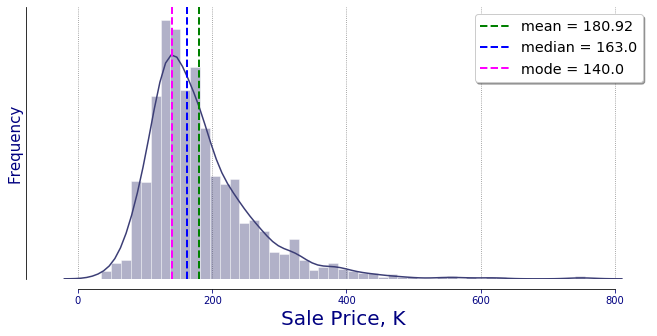

In [98]:
s = df['SalePrice'].dropna() 

fig = plt.figure(figsize=(11,5))
g = sns.distplot(s, kde=True)
g.set_xlabel('Sale Price, K', fontsize=20, color='navy')
g.set_ylabel('Frequency', fontsize=15, color='navy')
plt.xticks(rotation=45)
plt.yticks([])

xcoords = [round(s.mean(), 2), round(s.median(),2), round(s.mode()[0],2)]
xlabel = ['mean', 'median', 'mode']
colors = ['green', 'blue', 'magenta']
for x, xc, c in zip(xlabel, xcoords, colors):
    plt.axvline(x=xc, label='{} = {}'.format(x, xc), c=c, linestyle='--', linewidth=2)
plt.legend(bbox_to_anchor=(1, 1), loc=1, ncol=1, shadow=True, title='', fancybox=True, fontsize = 'x-large')

sns.despine(offset=10, trim=True)
plt.show()

In [99]:
# outliers
df = df.drop(df[(df['SalePrice'] > 400)].index, axis=0)
len(df)

2891

### ordinal features

In [100]:
ordin = ddict[ddict['Type']=='ordinal'].index
len(ordin)

11

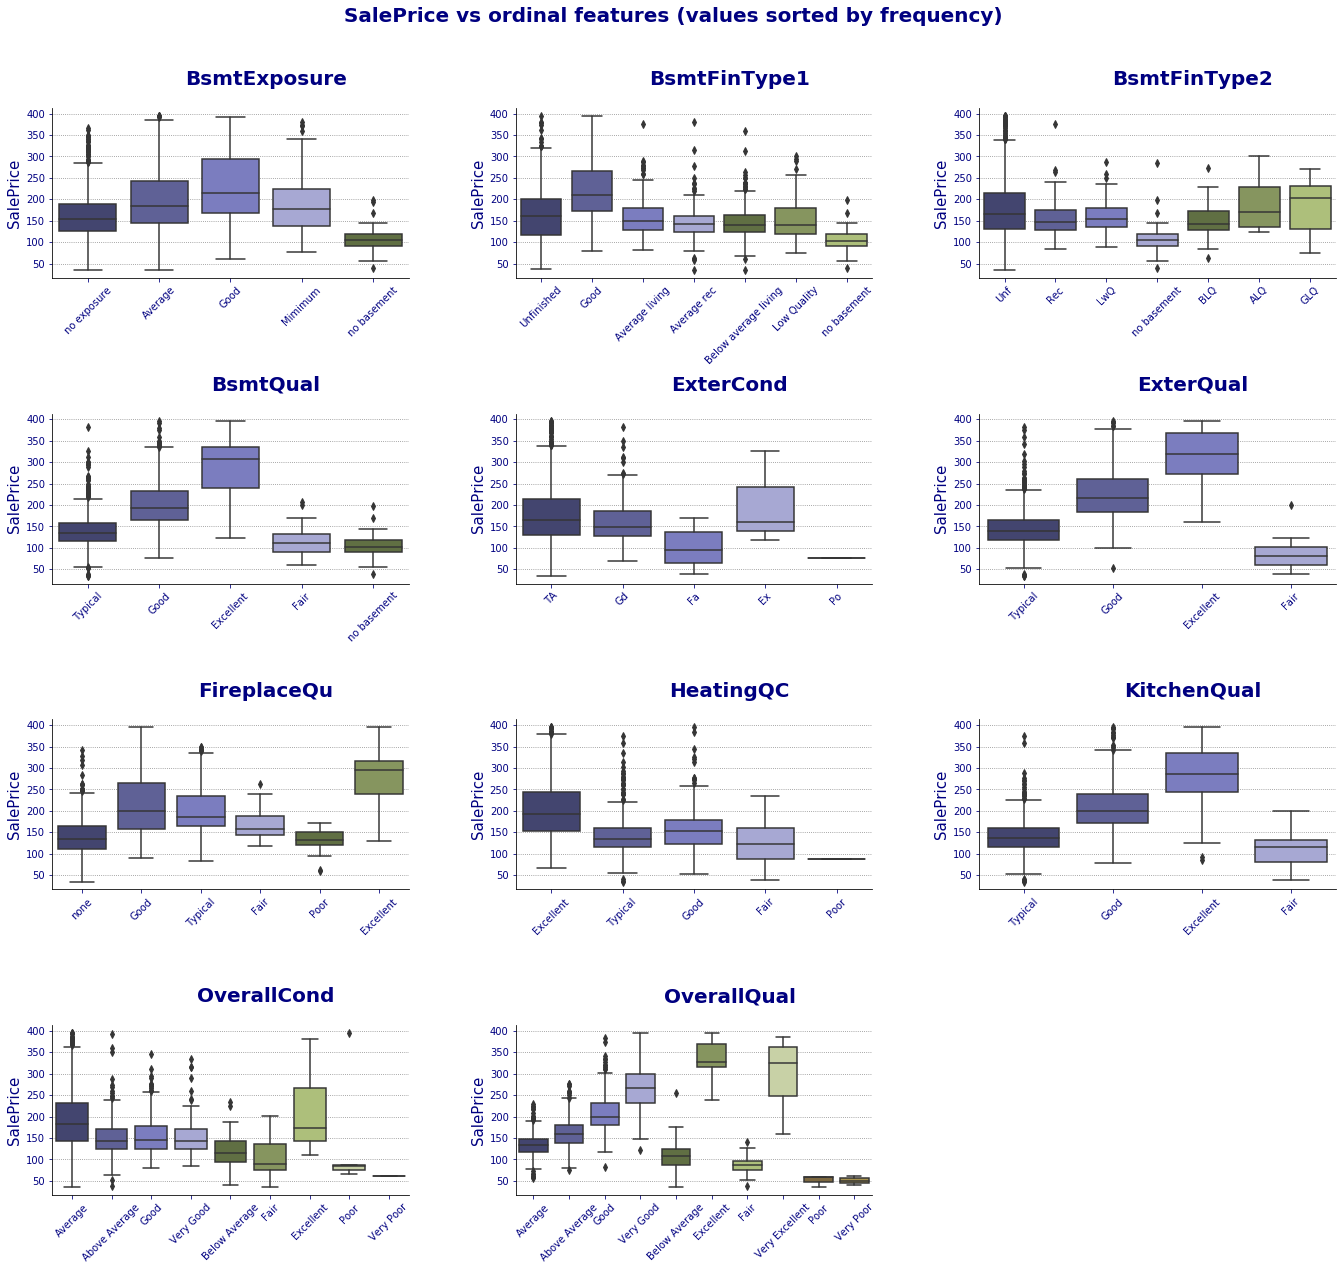

In [101]:
fig = plt.figure(figsize=(23,20))
fig.subplots_adjust(hspace=.8, wspace=.3)
fig.suptitle('SalePrice vs ordinal features (values sorted by frequency)', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)
for i in range(1, 12):
    s = df[ordin[i-1]]
    order = s.value_counts().to_frame().index.to_list()
    ax = fig.add_subplot(4, 3, i)
    g = sns.boxplot(x=s,order=order, y='SalePrice', data=df)
    ax.set_title(g.get_xlabel(),fontsize=20, color='navy', weight='heavy', x=0.6, y=1.1)
    g.set_xlabel(' ')
    g.set_ylabel(g.get_ylabel(),fontsize=15, color='navy')
    plt.xticks(rotation=45)

### nominal features

In [102]:
nom = ddict[ddict['Type']=='nominal'].index
len(nom)

19

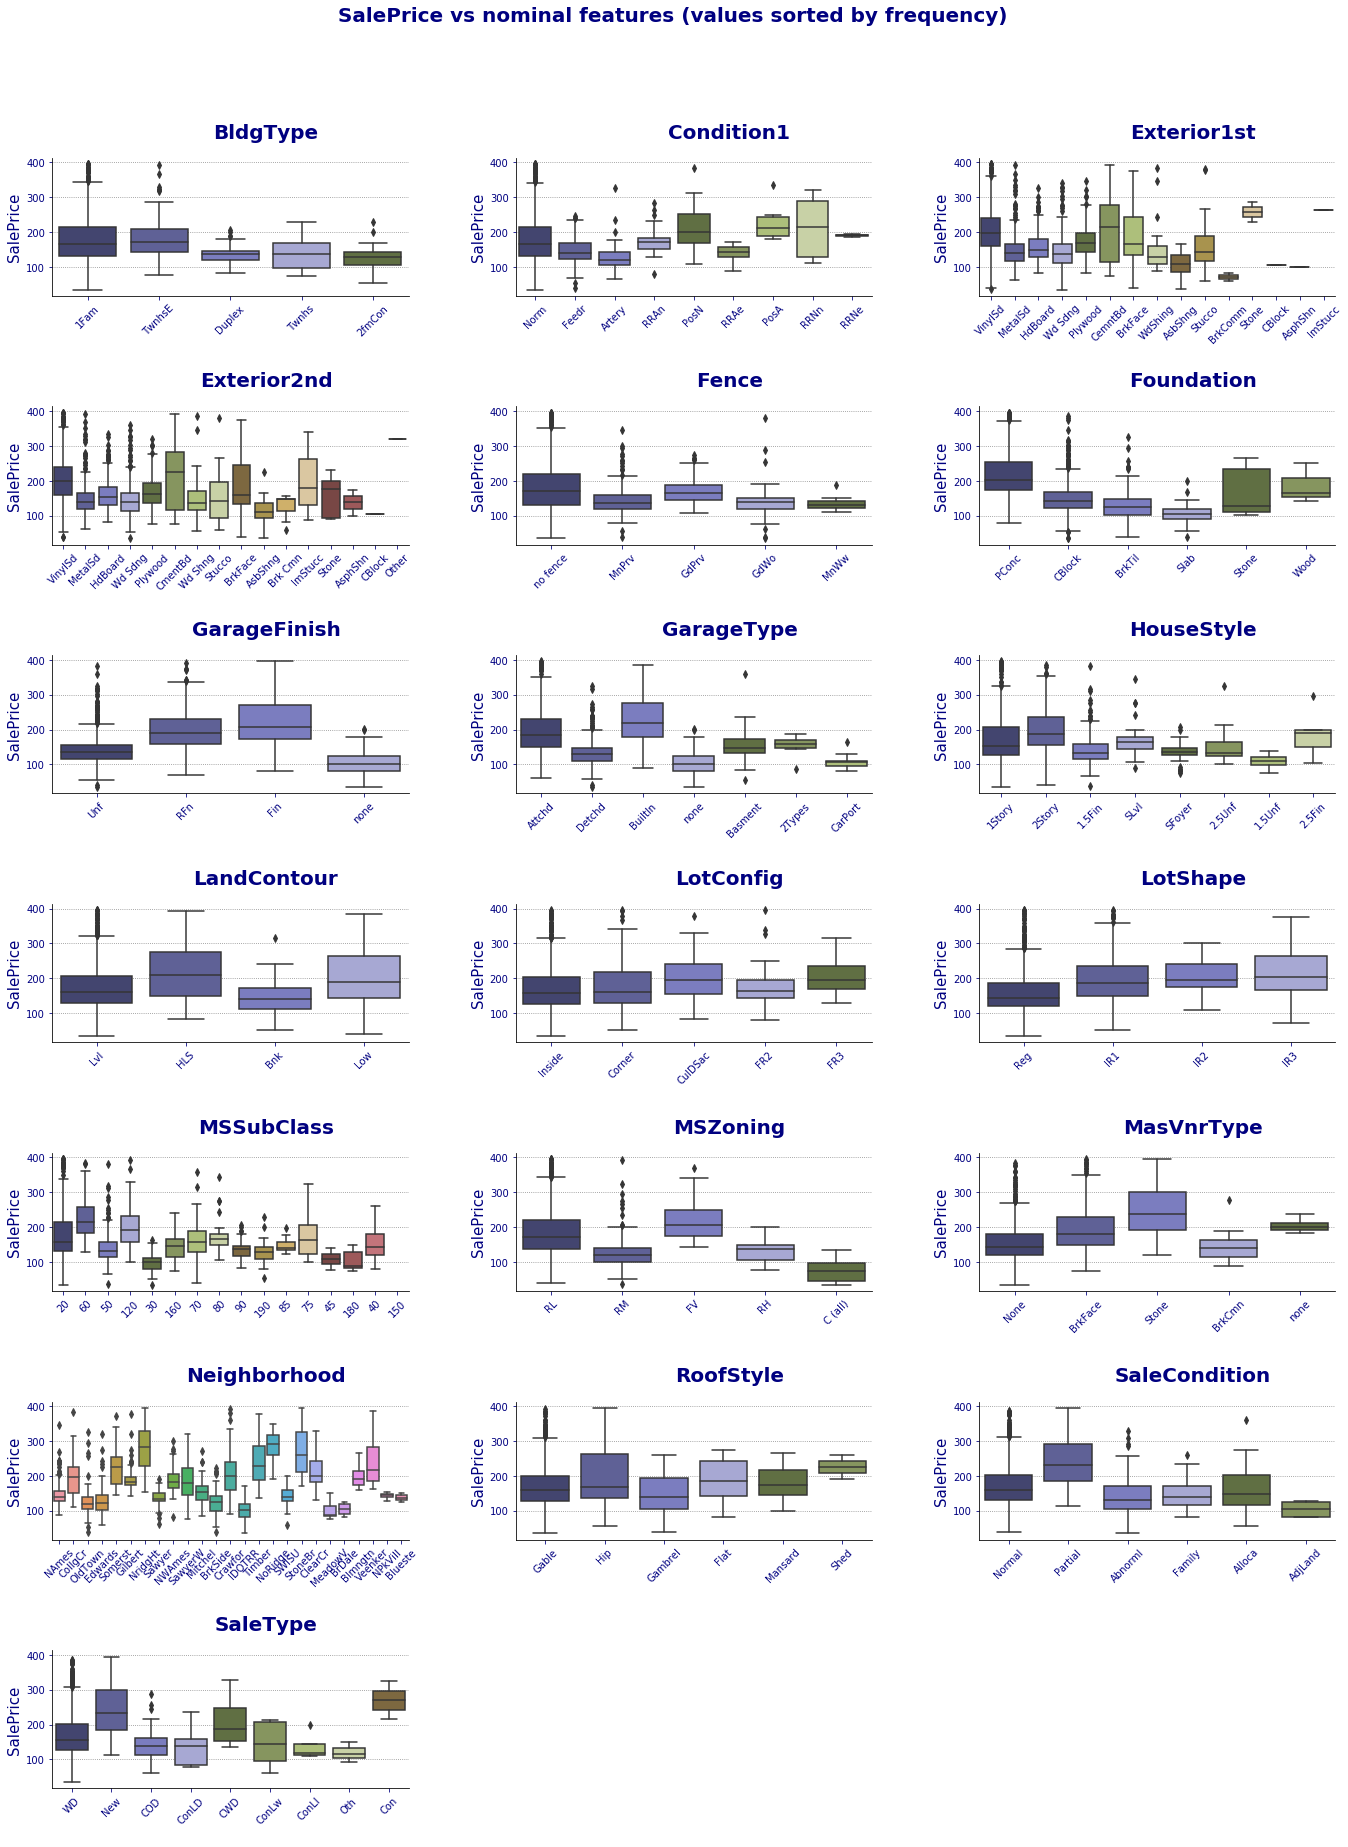

In [103]:
fig = plt.figure(figsize=(23,30))
fig.subplots_adjust(hspace=.8, wspace=.3)
fig.suptitle('SalePrice vs nominal features (values sorted by frequency)', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)

for i in range(1, 20):
    s = df[nom[i-1]]
    order = s.value_counts().to_frame().index.to_list()
    ax = fig.add_subplot(7, 3, i)
    g = sns.boxplot(x=s,order=order, y='SalePrice', data=df)
    ax.set_title(g.get_xlabel(),fontsize=20, color='navy', weight='heavy', x=0.6, y=1.1)
    g.set_xlabel(' ')
    g.set_ylabel(g.get_ylabel(),fontsize=15, color='navy')
    plt.xticks(rotation=45)

### time features

In [104]:
#t = ddict[ddict['Type']=='time'].index
t=['YearBuilt','GarageYrBlt', 'YearRemodAdd']

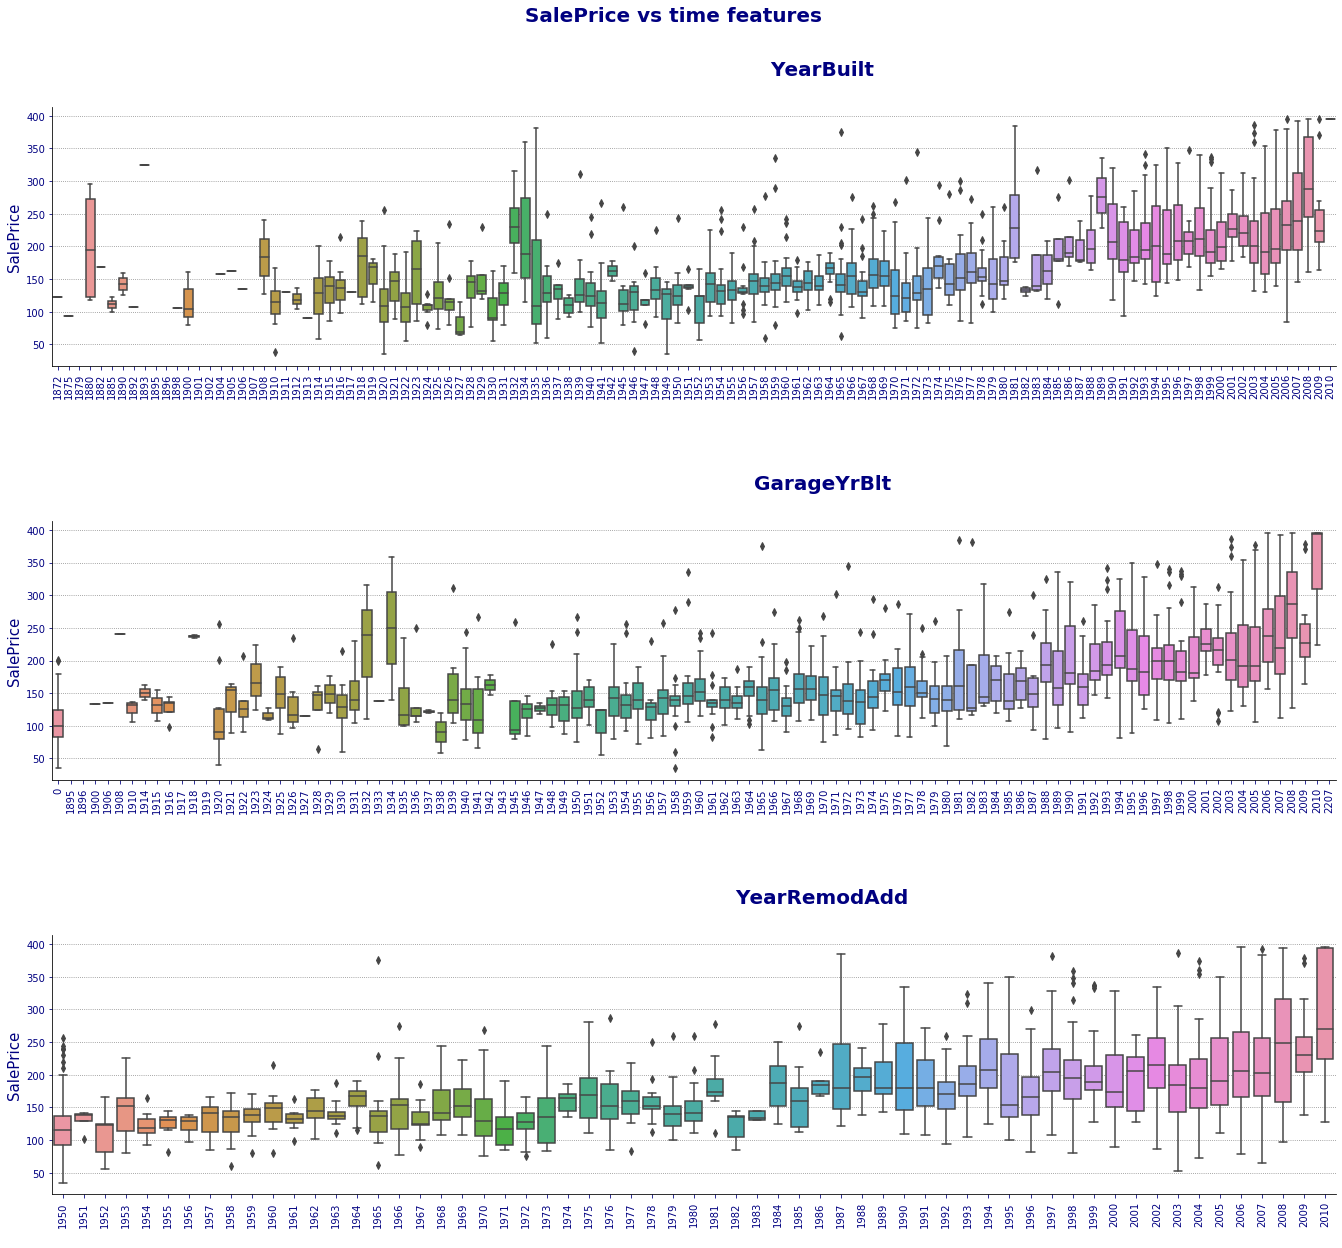

In [105]:
fig = plt.figure(figsize=(23,20))
fig.subplots_adjust(hspace=.6, wspace=.3)
fig.suptitle('SalePrice vs time features', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)

for i in range(1, 4):
    s = df[t[i-1]]
    ax = fig.add_subplot(3, 1, i)
    g = sns.boxplot(x=s, y='SalePrice', data=df)
    ax.set_title(g.get_xlabel(),fontsize=20, color='navy', weight='heavy', x=0.6, y=1.1)
    g.set_xlabel(' ')
    g.set_ylabel(g.get_ylabel(),fontsize=15, color='navy')
    plt.xticks(rotation=90)

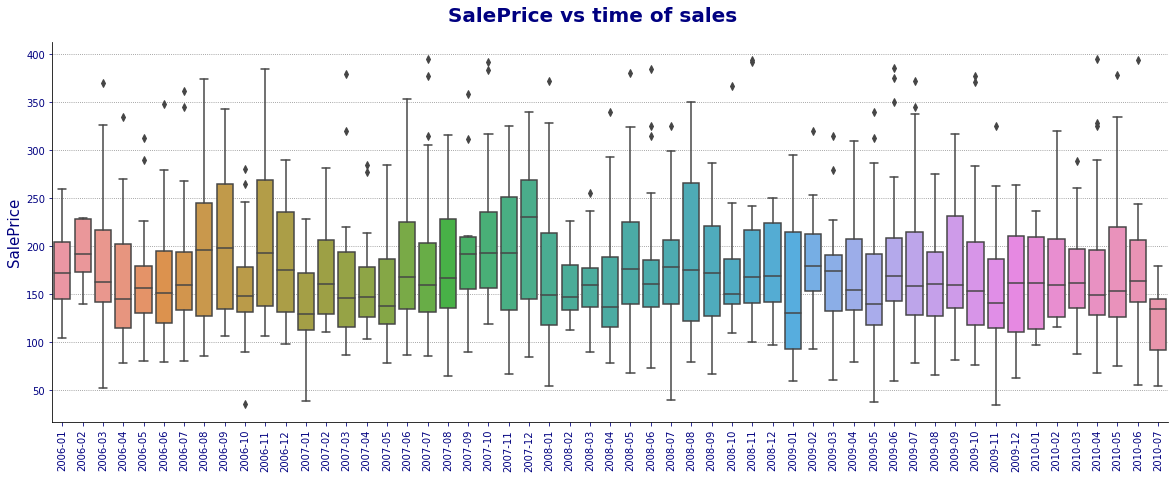

In [106]:
sold = ['YearMoSold']
fig = plt.figure(figsize=(20,7))
fig.subplots_adjust(hspace=.5, wspace=.5)
fig.suptitle('SalePrice vs time of sales', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)

for i in range(1, 2):
    s = df[sold[i-1]].dt.to_period('M')
    order = sorted(s.unique())
    ax = fig.add_subplot(1,1, i)
    g = sns.boxplot(x=s, order=order, y='SalePrice', data=df)
    g.set_xlabel(' ')
    g.set_ylabel(g.get_ylabel(),fontsize=15, color='navy')
    plt.xticks(rotation=90)

### discrete features

In [107]:
discr = ddict[ddict['Type']=='discrete'].index
len(discr)

7

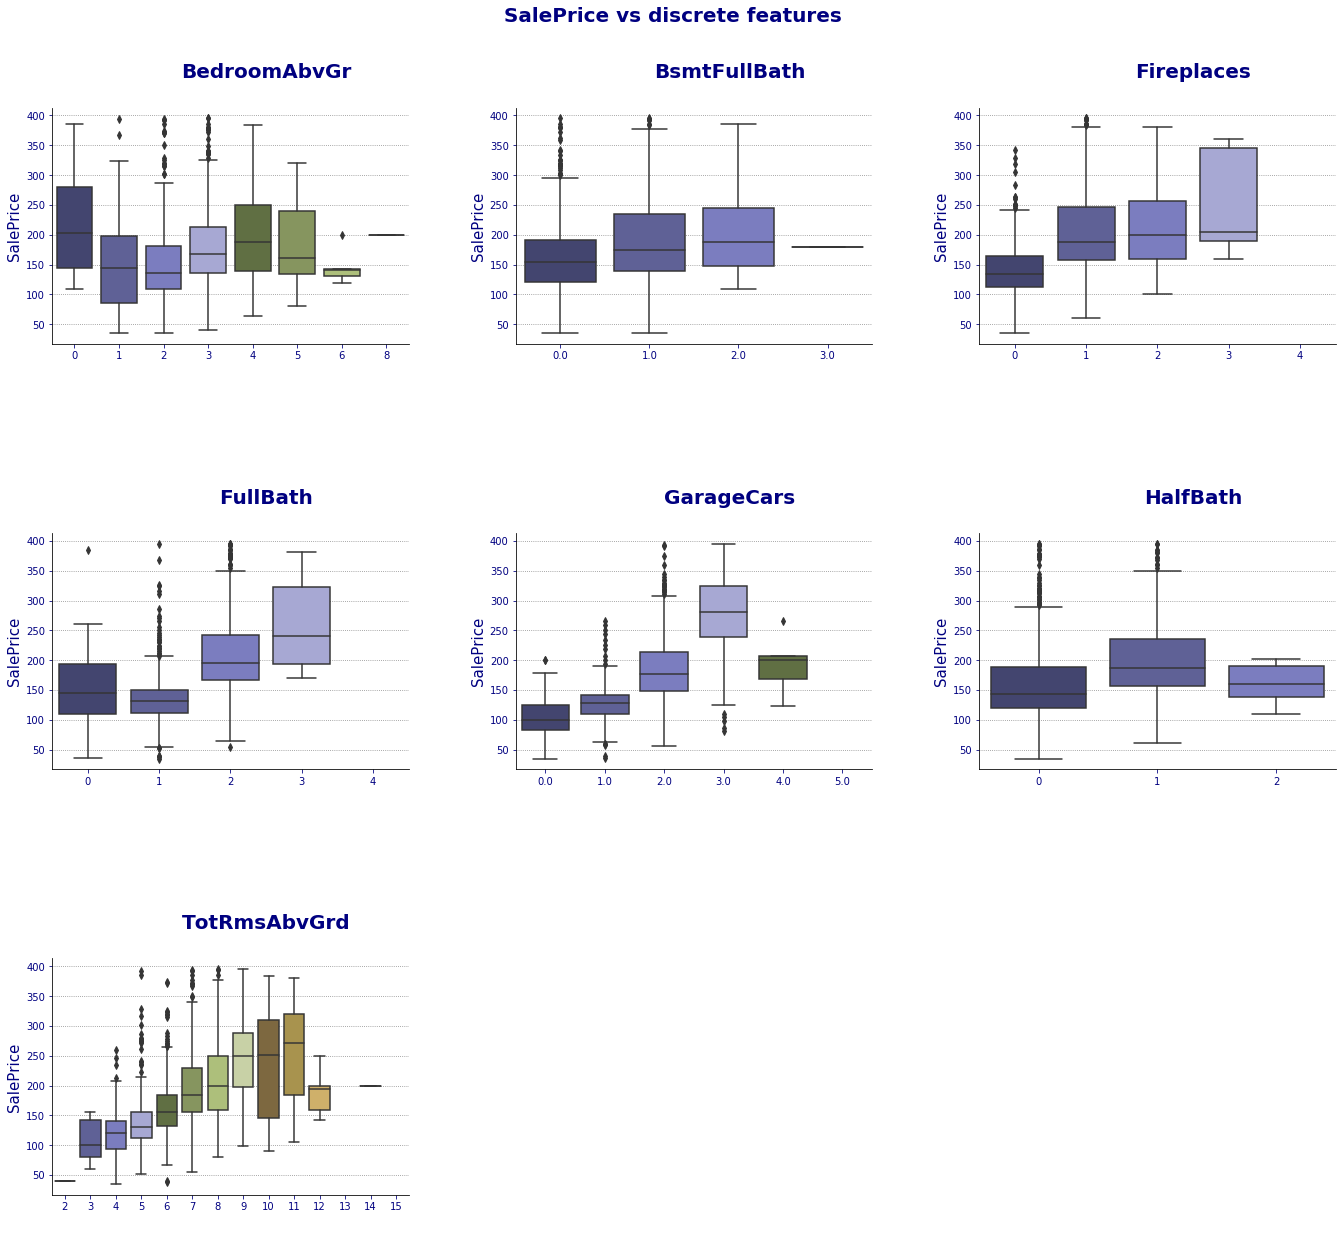

In [108]:
fig = plt.figure(figsize=(23,20))
fig.subplots_adjust(hspace=.8, wspace=.3)
fig.suptitle('SalePrice vs discrete features', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)

for i in range(1, 8):
    s = df[discr[i-1]]
    ax = fig.add_subplot(3, 3, i)
    g = sns.boxplot(x=s, y='SalePrice', data=df)
    ax.set_title(g.get_xlabel(),fontsize=20, color='navy', weight='heavy', x=0.6, y=1.1)
    g.set_xlabel(' ')
    g.set_ylabel(g.get_ylabel(),fontsize=15, color='navy')
    plt.xticks(rotation=0)

### continuous features

In [109]:
cont = ddict[ddict['Type']=='cont'].index
len(cont)

10

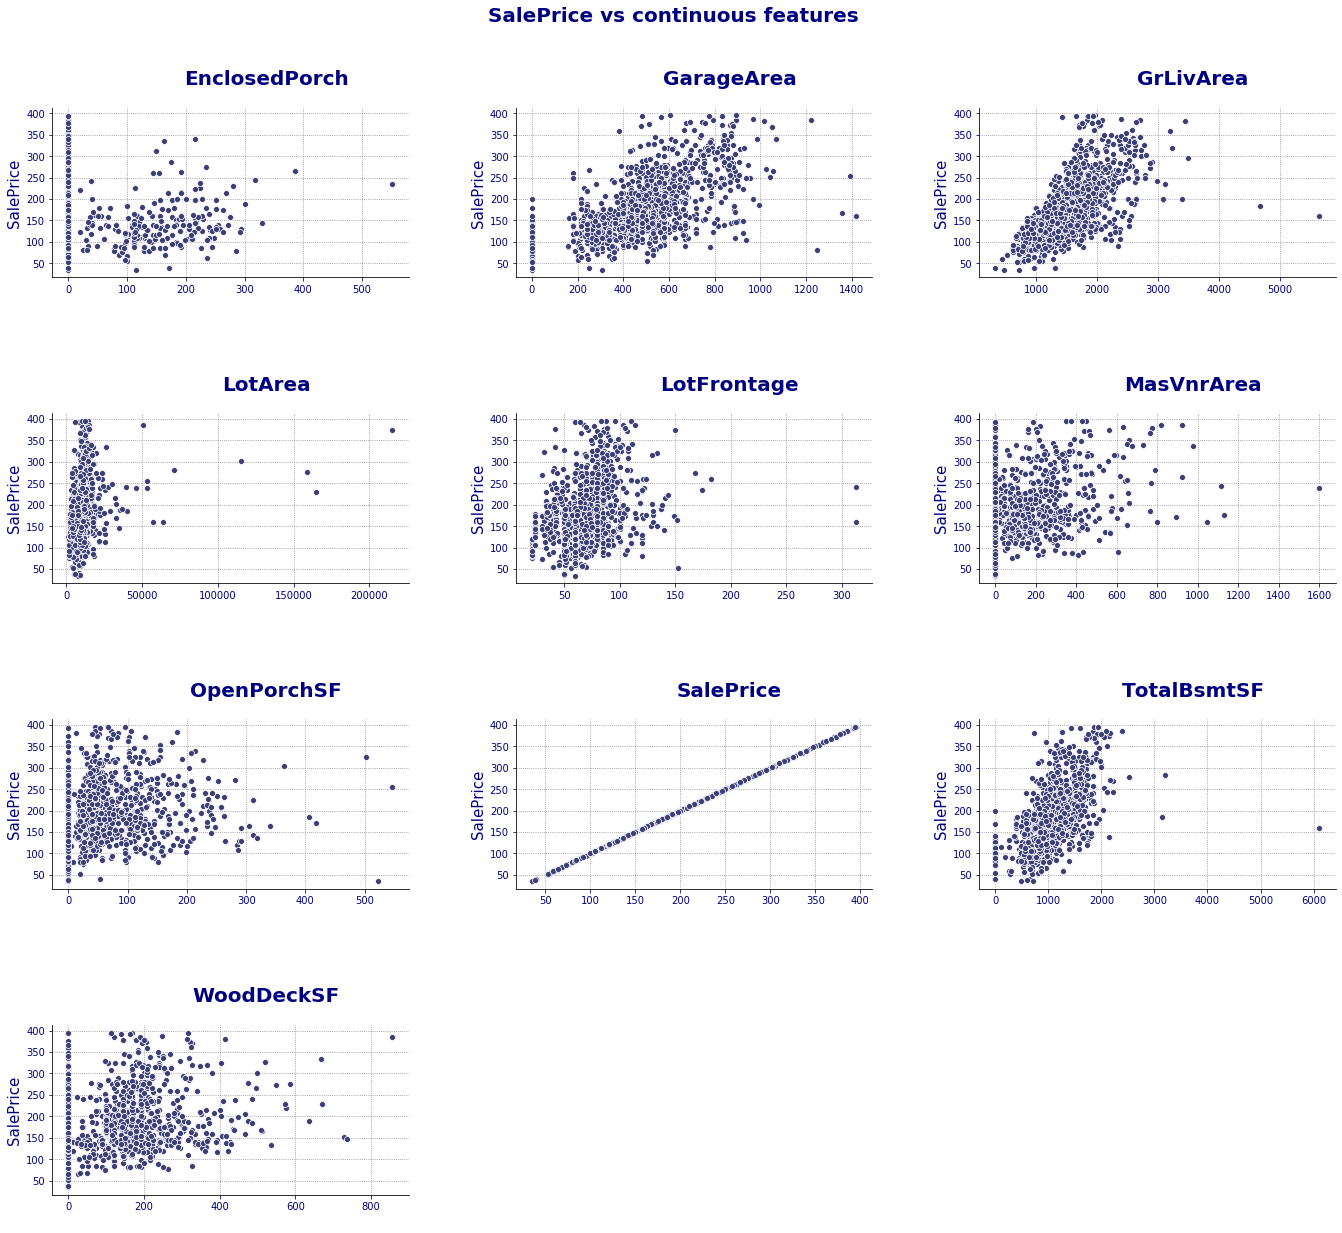

In [110]:
fig = plt.figure(figsize=(23,20))
fig.subplots_adjust(hspace=.8, wspace=.3)
fig.suptitle('SalePrice vs continuous features', fontsize=20, color='navy', weight='heavy', x=.5, y=.95)

for i in range(1, 11):
    s = df[cont[i-1]]
    ax = fig.add_subplot(4, 3, i)
    g = sns.scatterplot(x=s, y='SalePrice', data=df)
    ax.set_title(g.get_xlabel(),fontsize=20, color='navy', weight='heavy', x=0.6, y=1.1)
    g.set_xlabel(' ')
    g.set_ylabel(g.get_ylabel(),fontsize=15, color='navy')
    plt.xticks(rotation=0)

Let's remove outliers.

In [113]:
outliers=new_train.loc[(new_train['SalePrice']>400000)|(new_train['LotFrontage']>200)|(new_train['LotArea']>50000)|(new_train['SalePrice']>400000)].index
new_train.drop(outliers, axis=0, inplace=True)

### saving outputs

In [114]:
new_train.to_csv('...train_cleaned.csv', index=False)
new_test.to_csv('...test_cleaned.csv', index=False)

That's it!  
I've done here a data cleaning only, because I prefer to work with milestones.  